In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [2]:
# Specify the input image size for VGG19
img_size = (224, 224)

# Data Augmentation (commented out for comparison)
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size
batch_size = 32

# Specify the paths to your train, validation, and test data
train_dir = 'D:\Splitted Oversampled X-Ray Dataset\\train'
val_dir = 'D:\Splitted Oversampled X-Ray Dataset\\val'
test_dir = 'D:\Splitted Oversampled X-Ray Dataset\\test'

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',

)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle = False
)

Found 6378 images belonging to 4 classes.
Found 795 images belonging to 4 classes.
Found 814 images belonging to 4 classes.


In [3]:
# Load the VGG-19 model with pretrained weights (excluding the top dense layers)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = models.Sequential()

# Add the VGG-19 base model
model.add(base_model)

# Flatten the output layer to 1 dimension
model.add(layers.Flatten())

# Add a fully connected layer with 256 hidden units and ReLU activation
model.add(layers.Dense(256, activation='relu'))

# Add a dropout layer for regularization
model.add(layers.Dropout(0.5))

# Add the final output layer with 4 classes for classification
model.add(layers.Dense(4, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,256,196
Trainable params: 25,691,396
Non-trainable params: 23,564,800
_________________________________________________________________


In [4]:
# Define the initial learning rate and the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Define the optimizer with the learning rate schedule
opt = optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with the specified number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=75,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stop]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/75
199/199 [==============================] - 121s 570ms/step - loss: 2.1135 - accuracy: 0.7454 - val_loss: 0.4068 - val_accuracy: 0.8333
Epoch 2/75
199/199 [==============================] - 105s 530ms/step - loss: 0.4987 - accuracy: 0.8057 - val_loss: 0.4358 - val_accuracy: 0.8073
Epoch 3/75
199/199 [==============================] - 106s 531ms/step - loss: 0.4570 - accuracy: 0.8185 - val_loss: 0.5047 - val_accuracy: 0.8164
Epoch 4/75
199/199 [==============================] - 106s 533ms/step - loss: 0.3984 - accuracy: 0.8267 - val_loss: 0.4063 - val_accuracy: 0.8359
Epoch 5/75
199/199 [==============================] - 106s 530ms/step - loss: 0.3913 - accuracy: 0.8397 - val_loss: 0.3997 - val_accuracy: 0.8294
Epoch 6/75
199/199 [==============================] - 106s 530ms/step - loss: 0.3650 - accuracy: 0.8522 - val_loss: 0.4229 - val_accuracy: 0.8229
Epoch 7/75
199/199 [==============================] - 105s 527ms/step - loss: 0.3239 - accuracy: 0.8684 - val_loss: 0.4838 -

In [5]:
from sklearn.metrics import classification_report

# Get predictions on the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_labels = tf.argmax(y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_labels, digits=4))

814/814 [==============================] - 17s 19ms/step

Classification Report:
                     precision    recall  f1-score   support

           COVID-19     0.9907    0.9640    0.9772       111
             Normal     0.9536    0.9829    0.9681       293
Pneumonia-Bacterial     0.7953    0.8910    0.8404       266
    Pneumonia-Viral     0.7358    0.5417    0.6240       144

           accuracy                         0.8722       814
          macro avg     0.8689    0.8449    0.8524       814
       weighted avg     0.8684    0.8722    0.8667       814



814/814 [==============================] - 16s 19ms/step


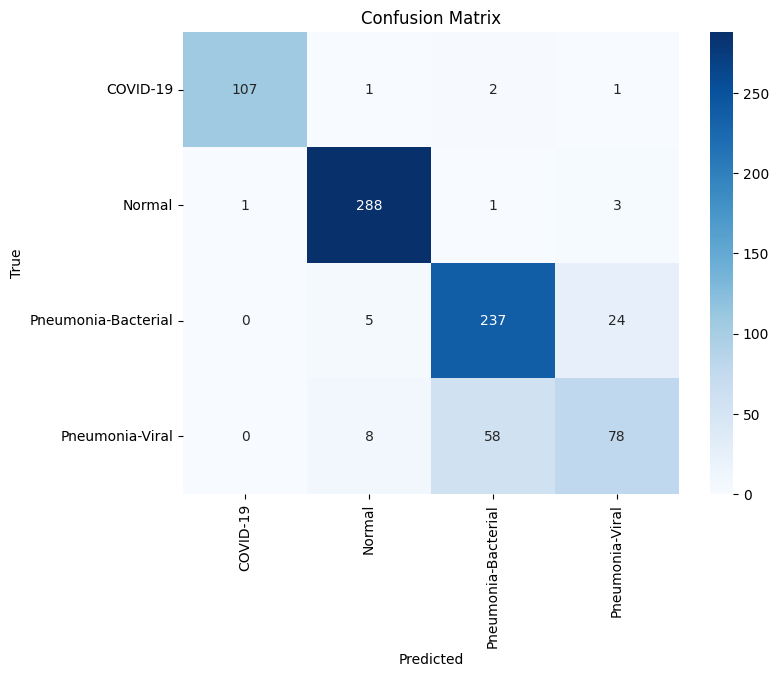

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict the classes for the test set
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Get the true classes for the test set
y_true = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
class_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']  # Adjust these based on your actual class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
